## Classifying the Arabic Tweets Without the Use of Machine Learning Algorithms

In [1]:
import pandas as pd
import random
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
df = pd.read_csv("Data/tweets_sent_ar.csv")

In [2]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'date', 'username', 'to', 'replies',
       'retweets', 'favorites', 'text', 'mentions', 'hashtags', 'id',
       'permalink', 'text_mentions', 'text_links', 'cleaned_text', 'language',
       'sentiment', 'hate'],
      dtype='object')

In [3]:
del df['Unnamed: 0']
del df['Unnamed: 0.1']
df.columns

Index(['date', 'username', 'to', 'replies', 'retweets', 'favorites', 'text',
       'mentions', 'hashtags', 'id', 'permalink', 'text_mentions',
       'text_links', 'cleaned_text', 'language', 'sentiment', 'hate'],
      dtype='object')

### Dropping English and Persian tweets, leaving only Arabic. I made some mistakes when I labelled the training set which I have to fix.

In [4]:
df['language'].unique()

array(['ar', 'en', 'no', '\tar', 'zr', 'en 2', 'fa'], dtype=object)

In [5]:
df.drop(df[df['language'].isin(["en", 'en 2', 'no', 'fa'])].index, inplace=True)

In [6]:
df['language'] = 'ar'

### Dropping the unnecessary characters and unifying the different variety of characters. 

In [7]:
def remove_unnecessary(txt):
    #remove extra space
    txt = ' '.join(txt.split())
    
    replA = ("أ", "إ", "آ")    
    chars_to_drop = ( 'ّ', 'َ', 'ِ', 'ُ', 'ْ', 'ً', 'ٍ', 'ٌ', 'ـ' )
    chars_to_clean = ('…','#', '@', '-', '_')
    txt = txt.replace("ة","ه")
    for a in replA:
        txt = txt.replace(a, "ا")
    for d in chars_to_drop:
        txt = txt.replace(d,"")
    for c in chars_to_clean:
        txt = txt.replace(c," ")
    return txt.strip()

In [8]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_unnecessary)

### Splitting the data into labelled and unlabelled sets

In [9]:
df_s = df[df['sentiment'].isna()]
df_s.reset_index(drop = True, inplace = True)

In [10]:
df_t = df.dropna(subset=['sentiment'])
df_t['sentiment'].unique()

array([-1.,  1.,  2.,  0.])

#### Drop the irrelevant tweets (labelled 2) and properly label the rest: 'O' for tweets that oppose the assassination, 'S' for tweets that support the assassination and 'N' for neutral tweets.

In [11]:
df_t.drop(df_t[df_t['sentiment'] == 2].index, inplace=True)
df_t.loc[df_t['sentiment'] == 0, 'sentiment'] = 'N'
df_t.loc[df_t['sentiment'] == 1, 'sentiment'] = 'O'
df_t.loc[df_t['sentiment'] == -1, 'sentiment'] = 'S'
df_t.reset_index(drop = True, inplace = True)
print(df_t['sentiment'].unique())
len(df_t)

['S' 'O' 'N']


C:\Users\laura\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\laura\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


937

### Determining the keywords that could indicate the sentiment of the tweets

In [12]:
su_list = ['عقبال','فرح' ,'فيلق الدجل', 'الحمدلله', 'الحمد لله', 'نفوق', 'جحيم', 'ملالي', 'نفق', 'لك الحمد', 'اهل السنه',
           'مجوس', 'الفرس', 'لا يرحمه', 'افرح', 'لايرحمه', 'ايفانكا', 'روافض', 'رافضي', 'خبر سعيد',
           'فارسي', 'مجرم', 'الارهاب الايراني', 'سار', 'قاتل الاطفال', 'احلى خبر', 'اجمل خبر', 'خنزير', 'مزبله',
           'لله الحمد', 'جمعه مباركه', 'ابريا', 'اطفال سوريا', 'القاتل بالقتل',
           'فطس', 'فطائس', 'فاطس', 'جهنم', 'مبروك', 'ارهابي', 'الظالمين بالظالمين', 'مبروک', 'هلاك', 'هالك', 'هلك'
          , 'العاقبه', 'بئس', 'ترتاح', 'كلب ', 'جرذ', 'دعس','احلا', 'يوم عظيم', 'لكل ظالم', 'كفو',
          'سلط الظالمين', 'ايفينكا', ' تفتح النفس ', 'ارواح المظلومين', 'يشف', 'قتل القاتل', 'ادخله النار', 'يمهل', 'مبارك', 'اجمل بدايه', 
          'چلب', 'ذيول', 'الظالمين بالظا', 'فطيس', 'تحسبن الله', 'الظالمين على', 'اشلاء', 'جيفه', 'صفوي', 'الخبيث',
          'الفرس', 'تفاح', 'الاصنام', 'ارهابي', 'المقبور', 'المتعه', 'عدو الله', 'لعنه الله', 'خونج', 'حسن زمير'
          ,'خبر اسعد', 'اليوم عيد', 'حوبه ', 'مع ابليس', 'ملعون', 'رفيق الحريري', 'نصر للانسانيه', 'راس الافع', 'اليرموك', 'جاء دور', 'تبارك'
          ]         

In [13]:
op_list = ['سيد','قائد' ,'عظم الله ', 'استشهاد', 'صهيون',
           'رايه', 'لروحك', 'يرزقون', 'سنثار', 'ثارالله', 'ثار الله',
           ' انتهاك', 'الاشتر', 'هنيئا', 'سلام على', 'جنه ',
           'الحسين', 'شهيدين', 'ننساك', 'عجل لوليك', 'رحمك الله',
           'حاج', 'سننتقم', 'انا لله', 'عزا', 'رد الحتمي', 'انتقامی سخت',
           'شهاده', 'رد قادم', 'شهىاء', 'شهيد', 'الموت', 'سننتقم'
          , 'غفرانا', 'قادتنا', 'رحلت', 'ايقظ', 'لا حول', 'منتقمون', 'ثوريه', 'طاهره', 'الجمهوريه الاسلاميه', 'الحسن ', 'يقتص',
          'بنو اميه', 'سلام الله', 'حتى ترضى', 'راس ترامب', 'راس ترمب', 'بسم رب الشه','جنات الخلد', 'قاصم ', 'المكان المناسب', 'رعبك', 'صلاه الع'
          , 'القدوه', 'رحلت', 'رد مفحم', 'مجاهد', 'لا زال حي', 'حامل اللوا', 'الوصال', 'ستلاحقكم'
          , 'دمائكم', 'نثار', 'الجبارين', ' سخت'
          ] 

### Classifying using the keywords

In [14]:
op_keywords = {}
su_keywords = {}

In [15]:
def process_tweets(row):
    for i in op_list:
        if i in row:
            if i in op_keywords:
                op_keywords[i] += 1
            else:
                op_keywords[i] = 1
            return 'O'
    for i in su_list:
        if i in row:
            if i in su_keywords:
                su_keywords[i] += 1
            else:
                su_keywords[i] = 1
            return 'S'
    return 'N'

In [16]:
df_s['sentiment'] = df_s['cleaned_text'].apply(process_tweets)

C:\Users\laura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df_op = df_s[df_s['sentiment'] == 'O']
print("Oppose: ", df_op.shape[0])
df_su = df_s[df_s['sentiment'] == 'S']
print("Suport: ", df_su.shape[0])
df_neu = df_s[df_s['sentiment'] == 'N']
print("Neutral: ", df_neu.shape[0])

Oppose:  27463
Suport:  32680
Neutral:  54021


In [18]:
op_keywords = {k: v for k, v in sorted(op_keywords.items(), key=lambda item: item[1], reverse = True)}
op_keywords

{'قائد': 5316,
 'شهيد': 3466,
 'سيد': 3275,
 'سننتقم': 2618,
 'عزا': 1190,
 'حاج': 1095,
 'الموت': 1082,
 ' سخت': 983,
 'استشهاد': 979,
 'شهاده': 864,
 'الحسين': 820,
 'هنيئا': 678,
 'رد الحتمي': 476,
 'جنه ': 424,
 'صهيون': 417,
 'سنثار': 404,
 'انتقامی سخت': 349,
 'رايه': 317,
 'حتى ترضى': 202,
 'قاصم ': 183,
 'انا لله': 173,
 'سلام على': 148,
 ' انتهاك': 143,
 'يرزقون': 141,
 'مجاهد': 138,
 'شهيدين': 136,
 'عظم الله ': 132,
 'الاشتر': 101,
 'الجبارين': 92,
 'طاهره': 91,
 'منتقمون': 83,
 'راس ترامب': 80,
 'لا حول': 70,
 'قادتنا': 67,
 'رحمك الله': 63,
 'المكان المناسب': 56,
 'لروحك': 56,
 'رد قادم': 48,
 'سلام الله': 47,
 'عجل لوليك': 46,
 'رحلت': 43,
 'ثوريه': 43,
 'يقتص': 41,
 'الجمهوريه الاسلاميه': 39,
 'الحسن ': 37,
 'رعبك': 36,
 'ايقظ': 36,
 'دمائكم': 30,
 'ثار الله': 21,
 'بسم رب الشه': 19,
 'جنات الخلد': 16,
 'بنو اميه': 12,
 'صلاه الع': 10,
 'نثار': 8,
 'ننساك': 6,
 'القدوه': 4,
 'ستلاحقكم': 3,
 'الوصال': 3,
 'راس ترمب': 3,
 'حامل اللوا': 2,
 'غفرانا': 1,
 'رد مفحم': 1}

In [19]:
su_keywords = {k: v for k, v in sorted(su_keywords.items(), key=lambda item: item[1], reverse = True)}
su_keywords

{'جهنم': 3371,
 'فرح': 3329,
 'مجرم': 2989,
 'ارهابي': 2307,
 'هلاك': 1714,
 'عقبال': 1691,
 'الحمدلله': 1178,
 'الحمد لله': 1167,
 'لك الحمد': 1052,
 'كلب ': 884,
 'جحيم': 869,
 'مجوس': 816,
 'هالك': 805,
 'ابريا': 628,
 'الظالمين بالظالمين': 611,
 'نفوق': 517,
 'ملالي': 477,
 'اهل السنه': 443,
 'هلك': 432,
 'سار': 408,
 'القاتل بالقتل': 404,
 'خنزير': 393,
 'فطس': 386,
 'الفرس': 373,
 'مزبله': 357,
 'فارسي': 342,
 'جمعه مباركه': 315,
 'ايفانكا': 311,
 'مبروك': 188,
 'ذيول': 185,
 'كفو': 174,
 'اطفال سوريا': 167,
 'يمهل': 166,
 'اجمل خبر': 160,
 'نفق': 156,
 'مبارك': 154,
 'لعنه الله': 151,
 'لله الحمد': 147,
 'تحسبن الله': 124,
 'اشلاء': 122,
 'يشف': 115,
 'احلى خبر': 113,
 'لا يرحمه': 108,
 'دعس': 106,
 'فطيس': 106,
 'لايرحمه': 103,
 'رافضي': 101,
 'قاتل الاطفال': 99,
 'حسن زمير': 94,
 'روافض': 87,
 'احلا': 86,
 'تفاح': 83,
 'بئس': 81,
 'جرذ': 81,
 'الخبيث': 63,
 'ملعون': 62,
 'المقبور': 53,
 'الارهاب الايراني': 48,
 'صفوي': 47,
 'رفيق الحريري': 45,
 'خونج': 43,
 'حوبه ': 40,
 'راس 

### Printing 100 randomly-selected tweets from each category, and counting the correctly classified and misclassified ones

In [20]:
df_neu.reset_index(drop = True, inplace = True)
n = random.sample(range(df_neu.shape[0]-1), 100)
for i in n:
    print(df_neu.loc[i]['cleaned_text'])
    print("===============================")

Rip solemani  قاسم سليماني
قاسم سليماني
قاسم سليماني
HardRevenge  قاسم سليماني  الحشد الشعبي  ابو مهدي المهندس  سردار سلیمانی  Soleimani
HardRevenge  قاسم سليماني
وصلت لقناعه انو الاشقاء العرب ما بعمرن رح يعترفوا بانتصارات محور المقاومه و ح يضلو يقللو منن و يخترعوا نظريات ليبرروا اذلالن لاميركا ، انو يابا كلنا مذلولين ما حادا احسن محدا  فالج لا تعالج  قاسم سليماني  عين الاسد
نائب الرئيس الاميركي يسرد الفظائع التي ارتكبها  قاسم سليماني.. منها تخطيطه لمحاوله اغتيال السفير السعودي في  واشنطن ووقوفه وراء استهداف المطارات المدنيه في  السعوديه
مفيش حد في العالم كله اتعملت له جنازات زي بتاعت  قاسم سليماني.. مش مجرد جنازه لا جنازات متعدده.. حدث تاريخي.. بجد مفيش اعظم من كده نهايه.
وراينا من يتباكى على من قتل المسلمين في  العراق و  سوريا و  اليمن ويعزي فيه خامنئي ويدفع المال ايضا تعويضا  قاسم سليماني و  قطر الخيانه . فلا غرابه من الغريب
قاسم سليماني
الاذاعه والتلفزيون الرسميان الايرانيان يؤكدان مقتل اللواء  قاسم سليماني
العراق  العراق ينتفض  نازل اخذ حقي  نريد وطن  ماكو وطن ماكو دوام  قاسم سليم

In [21]:
neu = 85
op = 8
su = 7
predicted = ['N'] * 100
print(len(predicted))
actual = ['N']*neu + ['O']*op + ['S']*su
print(len(actual))

100
100


In [22]:
df_op.reset_index(drop = True, inplace = True)
n = random.sample(range(df_op.shape[0]-1), 100)
for i in n:
    print(df_op.loc[i]['cleaned_text'])
    print("===============================")

هذه الجنه قد فتحت ابوابها قم يا علي العصر واستقبل الاشتر.. هذه جنودك طوع يديك جاهزه لتثار.. قم يا قائم ال محمد فنحن بك ننصر. اما ان الاوان يا بن فاطمه لتظهر..  سنثار سنثار  قاسم سليماني
قاسم سليماني احلى صوره له وهو مقطع الاطراف محروقا مشوها الحمد لله الذي انتقم للضعفاء والايتام والبعبع المجرمين، حركه الاخوان المفسدين، حماس الفلسطينيه تنعي قائدها والله لن تتحرر فلسطين الا بعد هلاك حركه حماس عميله الصهاينه
قاسم سلیمانی بلح  سننتقم بلح  انتقام سخت بلح  امام الخامنه ای دا بالذات بلحين اه بلحين بس مش اكتر
بسم الله قاسم الجبارين سنقول بان  القصاص العادل ل  قاسم سليماني وكل رفاقه الشهداء بانهم  سيعودون بالنعوش.
انباء عن استشهاد  قاسم سليماني
تفاصيل مقتل  قاسم سليماني قائد فيلق  القدس في  العراق التفاصيل:  صدى البلد  قناه صدى البلد .twitter.com/vrOplSHvk قائد فيلق  القدس في  العراق التفاصيل:  صدى البلد  قناه صدى البلد .twitter.com/vrOplSHvkW
الشهاده شرف عظيم وتاج على الرؤوس لايناله الانذال المجرمون  قاسم سليماني
يا نظره الحنين، قد فزت في جنب الحسين...  قاسم سليماني
اللي انبسط باستشهاد  قاسم س

In [23]:
neu = 9
su = 14
op = 77
p = ['O']*100
a = ['O']*op + ['N']*neu + ['S']*su
print(len(a))
actual += a
predicted +=p

100


In [24]:
df_su.reset_index(drop = True, inplace = True)
n = random.sample(range(df_su.shape[0]-1), 100)
for i in n:
    print(df_su.loc[i]['cleaned_text'])
    print("===============================")

قاسم سليماني لعنه الله على امريكا النجس قاسم سليماني له سنين وهو يقتل المسلمين السنه منهم النساء والاطفال في العراق وسوريا ولبنان واليمن يوم وصل الخطر السفاره الامريكيه اقتلوه بعد يوميين
اللهم لك الحمد ونسال الله ان يحفظ بلادنا وبلاد المسلمين من كل شر  قاسم سليماني
لكل ظالم نهايه والف لعنه يا مجرمي الارض  قاسم سليماني
قاسم سليماني مايفلح الفاجر ولا يسلم الجاني والابرياء دمهم ماضاع عند الله الله لايرحمك ي قاسم سليماني والدور باقي على الحوثي وحزب الله
جهنم وبئس المصير دماء اطفال العراق و سوريا واليمن تلاحقه بالدنيا والاخره هذه نتيجه حتميه لكل طاغيه ظالم  قاسم سليماني
بعد نفوق  قاسم سليماني السرا على رئيس حزباله ابو السراديب  حسن نصرالله
قاسم سليماني الى جهنم و بئس المصير
خسئت الوجوه وعقبال زبانيته بئس المصير  قاسم سليماني
الحمد لله الذي اهلك فرعون هذه المنطقه  قاسم سليماني ( قاتل الرجال والنساء والاطفال)
الحمد لله من قبل ومن بعد مقتل ابن الكلب  قاسم سليماني
المتظاهرون في  النجف يحرقون صور المجرم  قاسم سليماني  شباب التغيير قناتنا على التليغرام :
الافراح تعم ارجاء الوطن العربي بهالك  قاسم

In [25]:
neu = 9
su = 89
op = 2
p = ['S']*100
a = ['O']*op + ['N']*neu + ['S']*su
print(len(a))
actual += a
predicted +=p

100


### Most frequently used words in each category

In [26]:
op_keywords = {k: v for k, v in sorted(op_keywords.items(), key=lambda item: item[1], reverse = True)}
op_keywords

{'قائد': 5316,
 'شهيد': 3466,
 'سيد': 3275,
 'سننتقم': 2618,
 'عزا': 1190,
 'حاج': 1095,
 'الموت': 1082,
 ' سخت': 983,
 'استشهاد': 979,
 'شهاده': 864,
 'الحسين': 820,
 'هنيئا': 678,
 'رد الحتمي': 476,
 'جنه ': 424,
 'صهيون': 417,
 'سنثار': 404,
 'انتقامی سخت': 349,
 'رايه': 317,
 'حتى ترضى': 202,
 'قاصم ': 183,
 'انا لله': 173,
 'سلام على': 148,
 ' انتهاك': 143,
 'يرزقون': 141,
 'مجاهد': 138,
 'شهيدين': 136,
 'عظم الله ': 132,
 'الاشتر': 101,
 'الجبارين': 92,
 'طاهره': 91,
 'منتقمون': 83,
 'راس ترامب': 80,
 'لا حول': 70,
 'قادتنا': 67,
 'رحمك الله': 63,
 'المكان المناسب': 56,
 'لروحك': 56,
 'رد قادم': 48,
 'سلام الله': 47,
 'عجل لوليك': 46,
 'رحلت': 43,
 'ثوريه': 43,
 'يقتص': 41,
 'الجمهوريه الاسلاميه': 39,
 'الحسن ': 37,
 'رعبك': 36,
 'ايقظ': 36,
 'دمائكم': 30,
 'ثار الله': 21,
 'بسم رب الشه': 19,
 'جنات الخلد': 16,
 'بنو اميه': 12,
 'صلاه الع': 10,
 'نثار': 8,
 'ننساك': 6,
 'القدوه': 4,
 'ستلاحقكم': 3,
 'الوصال': 3,
 'راس ترمب': 3,
 'حامل اللوا': 2,
 'غفرانا': 1,
 'رد مفحم': 1}

In [27]:
su_keywords = {k: v for k, v in sorted(su_keywords.items(), key=lambda item: item[1], reverse = True)}
su_keywords

{'جهنم': 3371,
 'فرح': 3329,
 'مجرم': 2989,
 'ارهابي': 2307,
 'هلاك': 1714,
 'عقبال': 1691,
 'الحمدلله': 1178,
 'الحمد لله': 1167,
 'لك الحمد': 1052,
 'كلب ': 884,
 'جحيم': 869,
 'مجوس': 816,
 'هالك': 805,
 'ابريا': 628,
 'الظالمين بالظالمين': 611,
 'نفوق': 517,
 'ملالي': 477,
 'اهل السنه': 443,
 'هلك': 432,
 'سار': 408,
 'القاتل بالقتل': 404,
 'خنزير': 393,
 'فطس': 386,
 'الفرس': 373,
 'مزبله': 357,
 'فارسي': 342,
 'جمعه مباركه': 315,
 'ايفانكا': 311,
 'مبروك': 188,
 'ذيول': 185,
 'كفو': 174,
 'اطفال سوريا': 167,
 'يمهل': 166,
 'اجمل خبر': 160,
 'نفق': 156,
 'مبارك': 154,
 'لعنه الله': 151,
 'لله الحمد': 147,
 'تحسبن الله': 124,
 'اشلاء': 122,
 'يشف': 115,
 'احلى خبر': 113,
 'لا يرحمه': 108,
 'دعس': 106,
 'فطيس': 106,
 'لايرحمه': 103,
 'رافضي': 101,
 'قاتل الاطفال': 99,
 'حسن زمير': 94,
 'روافض': 87,
 'احلا': 86,
 'تفاح': 83,
 'بئس': 81,
 'جرذ': 81,
 'الخبيث': 63,
 'ملعون': 62,
 'المقبور': 53,
 'الارهاب الايراني': 48,
 'صفوي': 47,
 'رفيق الحريري': 45,
 'خونج': 43,
 'حوبه ': 40,
 'راس 

### Confusion Matrix

In [28]:
df_final = pd.concat([df_t, df_s])

In [29]:
df_final['sentiment'].unique()

array(['S', 'O', 'N'], dtype=object)

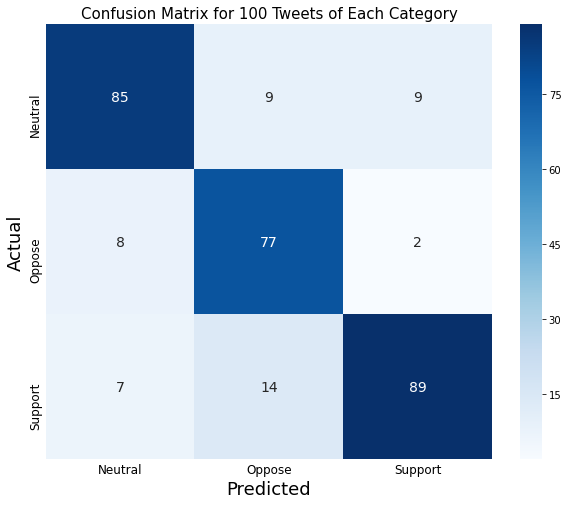

In [30]:
actu = np.array(actual)
predic = np.array(predicted)

confm = confusion_matrix(actu, predic)
c = [ 'Neutral', 'Oppose', 'Support']
df_cm = pd.DataFrame(confm, index=c, columns=c)
plt.subplots(figsize=(10,8))
ax = sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"fontsize":14})
xticks = ax.xaxis.get_major_ticks()
yticks = ax.yaxis.get_major_ticks()
for ts in [xticks, yticks]:
    for t in ts:
        t.label.set_fontsize(12)
        
ax.tick_params(axis='both', which='both',length=0)
ax.set_title('Confusion Matrix for 100 Tweets of Each Category', fontsize = 15)
ax.set_ylabel('Actual', fontsize = 18)
ax.set_xlabel('Predicted', fontsize = 18);

In [31]:
df_final.to_csv("Data/tweets_ar_classified.csv", index = False)